# Deep Learning with Python

## 8.4 Generating images with variational autoencoders

> 用变分自编码器生成图像

前两篇介绍的 DeepDream 和 Neural Style Transfer 都只是有限地“修改”现有作品。而下面我们要介绍地 GAN 和 VAE 则是更加富有创造性的，这两种技术都是从图像的潜在空间中采样，并创建全新图像或编辑现有图像。

- VAE：变分自编码器(Variational AutoEncoder)
- GAN：生成式对抗网络(Generative Adversarial Network)


### 从潜在空间采样

潜在空间(latent space)是一个向量空间，其中任意点都可以被映射为一张逼真的图像。而实现这种映射(潜在点->图像)的模块就是 GAN 的 generator，或者 VAE 的 decoder。

GAN、VAE 生成图像的关键就在于找到一个低维的「表示潜在空间」(latent space of representations)。一旦找到这样的潜在空间，从中采样，映射到图像空间，就可以生成全新的图像。

![学习图像的潜在向量空间，并利用这个空间来采样新图像](https://tva1.sinaimg.cn/large/007S8ZIlgy1ghut6hcq7kj317g0qyti6.jpg)

GAN 和 VAE 学习的潜在空间有很大的区别：

- VAE 善于学习具有良好结构的潜在空间，其中的特定方向可以编码(表示)数据中一个有意义的变化的轴。
- GAN 生成的图像可以非常逼真，但潜在空间缺乏良好的结构、没有足够的连续性。


### 概念向量

概念向量(concept vector)：给定一个表示的潜在空间或一个嵌入空间，空间中的特定方向可能表示原始数据中有意义的变化轴。例如对于图像，人脸图像的潜在空间中可能存在一个代表「微笑」这个概念的向量(称为微笑向量，smile vector)：对于代表某张人脸的潜在点 z，z+s 就是同一张人脸面带微笑的表示。

找到了这样的一些概念向量之后，我们就可以用这种方法来编辑图像了：将图像投射到潜在空间，和概念向量做运算来移动其表示，然后再解码到图像空间，就可以改变图像中的某一概念了——比如微笑程度：

![微笑向量](https://tva1.sinaimg.cn/large/007S8ZIlgy1ghuynp3pb9j31880kux67.jpg)


### 变分自编码器

自编码器是一种网络类型，接收一张图像，通过 encoder 模块将其映射到「潜在空间」，然后再通过 decoder 模块将其解码成与原始图像尺寸相同的输出。这东西训练时的目标是使输出和输入相同，所以我们把输入、输出用同一张图片。所以自编码器学习的是对原始输入进行重新构建。

通过对编码(编码器的输出)施加限制，可以让自编码器学到有用的数据潜在表示。比如限制编码要低维并且是稀疏的，这样编码器就可以将输入数据压缩为更少二进制位的信息：

![自编码器:将输入x映射为压缩表示，然后再将其解码为x’](https://tva1.sinaimg.cn/large/007S8ZIlgy1ghuz8fj78aj31ao0dwtbk.jpg)

变分自编码器 VAE，是一种现代化的自编码器。它是一种生成式模型，特别做利用概念向量进行图像编辑的任务。比起经典自编码器，VAE 可以学习更连续的、高度结构化的潜在空间。

VAE 不是将输入图像压缩成潜在空间中的固定编码，而是将图像转换为统计分布的参数——平均值和方差。VAE 解码的时候利用平均值和方差，从分布中随机采样一个元素，并将这个元素解码到原始输入。所以 VAE 的编码/解码过程是有一定的随机性的。

这个过程的随机性提高了 VAE 潜在空间的稳健性：VAE 需保证潜在空间采样的每个点都能解码为有效的输出，这迫使潜在空间的任何位置都对应有意义的表示。

![VAE 将一张图像映射为两个向量 z_mean 和 z_log_var，二者定义了潜在 空间中的一个概率分布，用于采样一个潜在点并对其进行解码](https://tva1.sinaimg.cn/large/007S8ZIlgy1ghuzfuik3jj31bi0piah3.jpg)

上图展现了 VAE 的工作原理：

1. Encoder 模块将输入样本 `input_img` 转换为表示潜在空间中的参数 `z_mean` 和 `z_log_variance`;
2. 从这个潜在正态分布中随机采样一个点 z: `z = z_mean + exp(z_log_variance) * epsilon`，其中 epsilon 是取值很小的随机张量;
3. Decoder 模块将这个潜在点映射回原始输入图像。

epsilon 是随机的，所以需要与 input_img 编码的潜在位置(z-mean)靠近的每个点都能被解码为与 input_img 类似的图像，这个性质迫使潜在空间能够连续地有意义：潜在空间中任意两个相邻的点都会被解码为高度相似的图像。连续性以及潜在空间的低维度，又迫使潜在空间中的每个方向都表示数据中一个有意义的变化轴，这样就可以通过概念向量来进行操作。

用 Keras 实现 VAE 的伪代码如下：

```python
z_mean, z_log_variance = encoder(input_img)
z = z_mean + exp(z_log_variance) * epsilon
reconstructed_img = decoder(z)
model = Model(input_img, reconstruced_img)
```

训练 VAE 需要两个损失函数：

- 重构损失(reconstruction loss)：使解码后的样本匹配初始输入;
- 正则化损失(regularization loss)：使潜在空间具有良好结构（连续性、概念向量可用性），同时也降低在训练数据上的过拟合;


我们具体实现编码器(encoder)网络：通过一个卷积神经网络，将输入图像 x 映射为两个向量 z_mean 和 z_log_var。

In [10]:
# 不使用及时执行模式

import tensorflow as tf

tf.compat.v1.disable_eager_execution()

In [11]:
# VAE 编码器网络

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
import numpy as np

img_shape = (28, 28, 1)
batch_size = 16
latent_dim = 2    # 潜在空间的维度：2D平面

input_img = keras.Input(shape=img_shape)
x = layers.Conv2D(32, 3, padding='same', activation='relu')(input_img)
x = layers.Conv2D(64, 3, padding='same', activation='relu', strides=(2, 2))(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)

shape_before_flattening = K.int_shape(x)

x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)

z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)


接下来的代码将使用 z_mean 和 z_log_var 来生成（采样）一个潜在空间点 z。

In [12]:
# 潜在空间采样的函数

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0.,
                              stddev=1.)
    return z_mean + K.exp(z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])    # 封装为层

然后是解码器的实现：将向量 z 的尺寸调整为图像大小，然后使用几个卷积层来得到最终的图像输出。

In [13]:
# VAE 解码器网络

decoder_input = layers.Input(K.int_shape(z)[1:])
x = layers.Dense(np.prod(shape_before_flattening[1:]),
                 activation='relu')(decoder_input)
x = layers.Reshape(shape_before_flattening[1:])(x)
x = layers.Conv2DTranspose(32, 3,
                           padding='same',
                           activation='relu',
                           strides=(2, 2))(x)
x = layers.Conv2D(1, 3,
                  padding='same',
                  activation='sigmoid')(x)

decoder = Model(decoder_input, x)

z_decoded = decoder(z)

VAE 要用两个损失，所以不能直接写成 `loss(input, target)`，我们需要编写一个自定义层，在其中使用内置的 `add_loss` 方法来创建需要的损失。

In [14]:
# 用于计算 VAE 损失的自定义层

class CustomVariationalLayer(keras.layers.Layer):
    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        kl_loss = -5e-4 * K.mean(
            1 + z_log_var - K.square(z_mean) - K.exp(z_log_var),
            axis=-1)
        return K.mean(xent_loss + kl_loss)
    
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        
        return x
    
y = CustomVariationalLayer()([input_img, z_decoded])

最后，将模型实例化并开始训练。由于我们的损失以及包含在自定义层里面了，所以编译时无须指定外部损失(`loss=None`)，所以也就不需要外部指定的目标数据(`y=None`)。

这里我们用 MNIST 去训练它，也就是生成手写数字的潜在空间。

In [15]:
from tensorflow.keras.datasets import mnist

vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()

(x_train, _), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))

x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

vae.fit(x=x_train, y=None,
        shuffle=True,
        epochs=10,
        batch_size=batch_size,
        validation_data=(x_test, None))

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_5[0][0]                   
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_6[0][0]                   
_______________________________________________________________________________________

训练好模型，我们就可以使用 decoder 将任意潜在空间中的向量转换为图像。

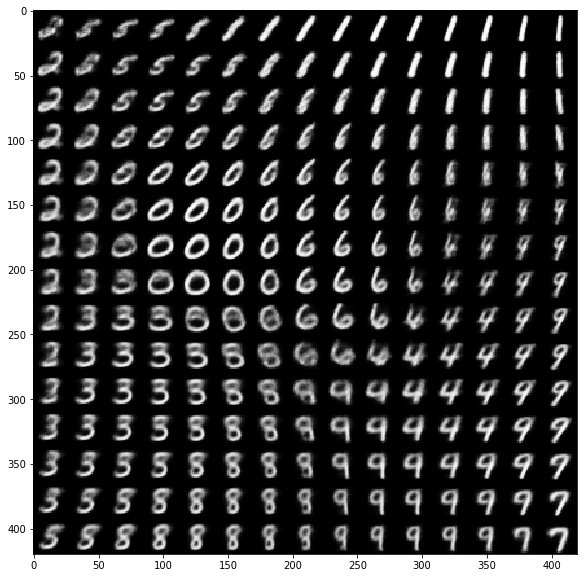

In [18]:
# 从潜在空间中采样一组点，解码为图像

import matplotlib.pyplot as plt
from scipy.stats import norm

n = 15    # 显示 15x15个数
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

grid_x = norm.ppf(np.linspace(0.05, 0.95, n))  # ppf 函数对线性分隔的坐标进行变换，以生成潜在变量 z 的值
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_simple = np.array([[xi, yi]])
        z_simple = np.tile(z_simple, batch_size).reshape(batch_size, 2)
        x_decoded = decoder.predict(z_simple, batch_size=batch_size)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

书上到这里就结束了，并没有深入写之前提到的概念向量的应用😂，好遗憾啊。